# Darren Hunt

PHYS 434AA

10-25-2020

Lab 3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd

# Part 1: Truth Table Tests for Temperature Data

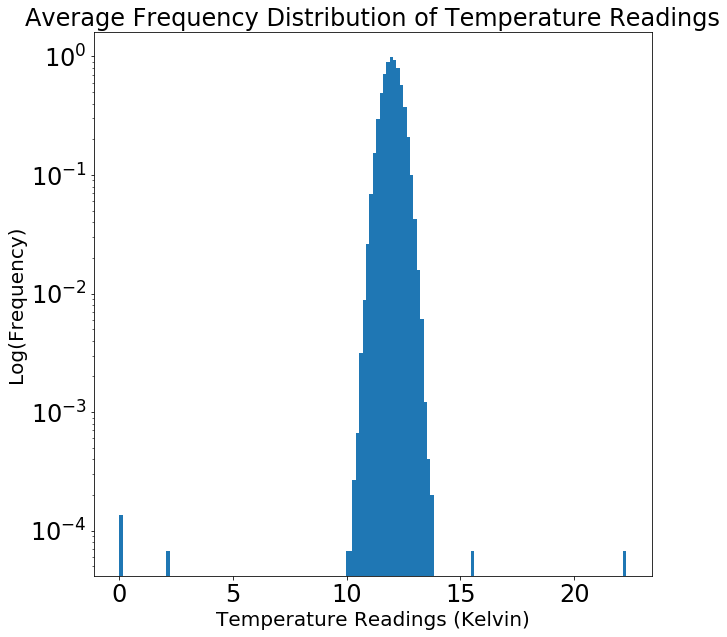

In [2]:
# random Gaussian data, and bad points
good = stats.norm.rvs(loc = 12., scale = 0.4, size = 100000)
bad = [10.0, 10.3, 2.1, 0.0, 0.0, 15.6, 22.3, 12.7]
bad = np.asarray(bad)
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_title("Average Frequency Distribution of Temperature Readings", fontsize=24)
ax.set_xlabel("Temperature Readings (Kelvin)", fontsize=20)
ax.set_ylabel("Log(Frequency)", fontsize=20)

ax.hist(d,150, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')

plt.show()

Here we have randomly generated "good" data in the form of a Gaussian distribution, and appended that data with an array of "bad" values. The continuous distribution in this plot follows a parabolic shape when we plot it as a semilog, while the random points of error that lie away from the mean do not follow any sort of continuous distribution.

We are trying to find a way mathematically to throw out as many bad data points as we can without throwing away the good ones. This means we are looking at how standard deviations make up the main distribution (the good data), then cut out any points that lie too far beyond this distribution (the bad data).

Therefore, we can ask the following statistical question: 

For a signal-free Gaussian distributed background with a mean of T=12 K, what is the optimal standard deviation value for the cutoff point of good data?

This statistical question translates mathematically to specific integrations under the continuous Gaussian distribution above. To find the cutoff point for good data in our statistical test, we need to integrate in between the estimated start and end of the continuous good data. This can be done by summing up the number of points that fall inside the curve. The data that is thrown out is integrated outside these bounds on either side (from the start of the dataset to the start of the Gaussian curve; from the end of the Gaussian curve to the end of the dataset), again done by summing up the number of points that fall within a given range. 

In [3]:
# Gaussian fit of the data
mu, std = stats.norm.fit(d)

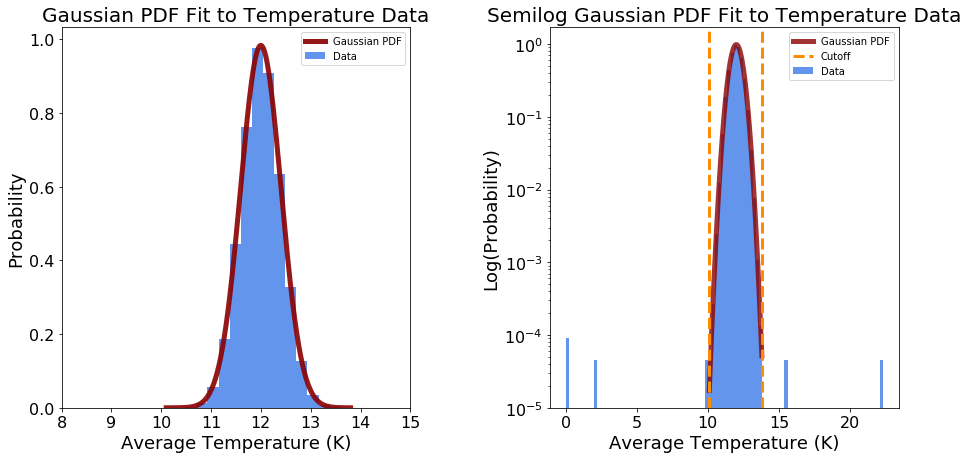

In [4]:
x = np.linspace(10.1,13.8,100000)
g = stats.norm.pdf(x,loc=mu,scale=std)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,7),gridspec_kw={'wspace': 0.4})
ax1.set_title("Gaussian PDF Fit to Temperature Data", fontsize=20)
ax2.set_title("Semilog Gaussian PDF Fit to Temperature Data", fontsize=20)
ax1.set_xlabel("Average Temperature (K)", fontsize=18), ax2.set_xlabel("Average Temperature (K)", fontsize=18)
ax1.set_ylabel("Probability", fontsize=18), ax2.set_ylabel("Log(Probability)", fontsize=18)
ax1.set_xlim(8,15)

ax1.plot(x,g, label="Gaussian PDF", color='darkred', alpha=0.9, linewidth=5)
ax1.hist(d,100, density=True, label="Data", color='cornflowerblue')

ax2.plot(x,g, label="Gaussian PDF", color='darkred', alpha=0.8, linewidth=5)
ax2.hist(d,100, density=True, label="Data", color='cornflowerblue')
ax2.set_yscale('log')

# guesses for the cutoff points
ax2.axvline(x=10.1, label='Cutoff', linestyle='--', linewidth=3, color='darkorange')
ax2.axvline(x=13.8, linestyle='--', linewidth=3, color='darkorange')

ax1.tick_params(labelsize=16), ax2.tick_params(labelsize=16)
ax1.legend(loc='best'), ax2.legend(loc='best')
plt.show()

In order to answer the proposed statistical question, I began by plotting a Gaussian probability density function over the histogram of good and bad data, fit to the mean and standard deviations pulled from the histogram. In the left plot, it visually appears that an estimated Gaussian fits quite well with the boundaries I chose (x=10.1 to x=13.8). However, once overplotting on the semilog of the histogram data, we can see it is not as exact as it appeared. The left plot doesn't visually include the bad outliers, and the semilog plot shows that the PDF does not *exactly* fit.

Since this is a statistical test to throw out as much bad data as possible and keep as much good data as possible, our fitted PDF to determine the bounds of the good data is just an estimate and not exact. This is why the red curve in the semilog plot does not cove the whole central histogram.

In [5]:
# calculate for truth table
goodTrue, goodFalse, badFalse, badTrue = [], [], [], []

def truth_table(mu, std, n):  # give 
    goodTrue = good[np.where((good < mu+(n*std)) & (good > mu-(n*std)))]  # good data inside of PDF
    badFalse = len(good) - len(goodTrue)  # good data outside PDF
    goodFalse = bad[np.where((bad < mu+(n*std)) & (bad > mu-(n*std)))]  # bad data inside of PDF
    badTrue = len(bad) - len(goodFalse)  # bad data outside of PDF

    truth = [[len(goodTrue),len(goodFalse)],[badFalse,badTrue]]
    ttable = pd.DataFrame(truth, columns=['True T', 'Bad T'], index=['Test Good', 'Test Bad'])
    return ttable

This function truth_table takes in the mean and one standard deviation of the fitted Gaussian PDF from above, and an *n* value indicating how many standard deviations out from the mean in either direction to apply the statistical test to. We can run it for different numbers of standard deviations out to examine how modifying the statistical threshold for good versus bad data impacts the output truth table for the test.

In [6]:
tt1 = truth_table(mu,std,1)
tt1

,True T,Bad T
Test Good,69038,0
Test Bad,30962,8


In [7]:
tt4 = truth_table(mu,std,4)
tt4

,True T,Bad T
Test Good,99995,1
Test Bad,5,7


In [8]:
tt45 = truth_table(mu,std,4.5)
tt45

,True T,Bad T
Test Good,99998,2
Test Bad,2,6


The cell "True T Test Good" is the number of good temperature data points that correctly fall within the cutoff points; the cell "Bad T Test Bad" is the number of bad outlier points that correctly fall outside of the cutoff points. The off diagonal cells are where the statistical test fail: bad data points kept (a mistake of commission; cell "Bad T Test Good") and good data points discarded (a mistake of omission, cell "True T Test Bad").

Note: when this code is rerun from the beginning, the truth table will have slightly different results, varying by a few points within the truth table, due to the fact that the input data is randomized.

By increasing the number of standard deviations to test out from the mean of the Gaussian PDF, we change the threshold which we are discarding data. For only 1 standard deviation, we have numerous errors of good data being thrown out; this is because we have not incorporated enough of the PDF in the distribution for calculation. At 4 standard deviations from the mean, we throw out around 7 of our 8 bad data points, but still hold some inevitable mistakes (lower comission of bad points, higher omission of good points). Finally, at 4.5 standard deviations, most or all good data points are captured in the estimated Gaussian PDF, but we commit more bad data points inside the threshold.

Therefore, by increasing the statistically significant threshold, we reduce the number of omitted good data points, but raising the standard deviation too much results in capturing bad data points under the curve. These mistakes are predictable but altering the threshold captures a mistake of some kind for the statistical test since it is not perfect, and some data points lie very close to the threshold.

In [9]:
ttclosest = truth_table(mu,std,4.17)
prb = stats.norm.cdf(4.17)
print("Sigma = 4.17; Probability of mistake from test : " + str(1-prb))
ttclosest

Sigma = 4.17; Probability of mistake from test : 1.5229981948028382e-05


,True T,Bad T
Test Good,99997,1
Test Bad,3,7


This final truth table is the result of the statistical test running 4.17 standard deviations from either side of the mean T=12. This is the closest trial to reduce omission and commission mistakes; increasing the standard deviation by even 0.01 will result in 2 bad data points being kept. The value of 4.17 std was found by repeatedly running the statistical test with human chosen values (not calculated by Python) until the truth table output achieved the most optimal results. Since the initial data is randomized, this sigma value can vary slightly by decimal values for the given dataset. The main goal is to keep comission mistakes minimized as the highest priority, we do not want bad data captured within our good distribution.

Therefore, the answer to my proposed statistical question, "For a signal-free Gaussian distributed background with a mean of T=12 K, what is the optimal standard deviation value for the cutoff point of good data?",is about $\sigma = 4.17$. This is the threshold that keeps both mistakes to a minimum, and at this threshold if we increase we will make too many commission mistakes, which are the "worse" of the two possible errors.

# Part 2: Positional Uncertainty with 2D Gaussians

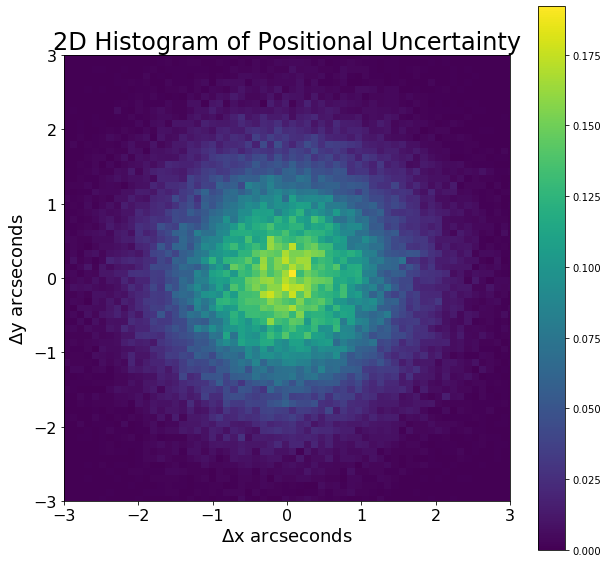

In [10]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape

fig, ax = plt.subplots(1, 1, figsize=(10,10))
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')

plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of Positional Uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)
plt.tick_params(labelsize=16)

plt.show()

This is a 2D Gaussian displaying the distributions of position uncertainty for hypothetical stars, which do not hold an exact/constant (x,y) position due to the atmosphere and observational instrumentation. If we are looking for an asteroid within this data, it will move significantly beyond the expected distribution of the star positional uncertainties; therefore we can calculate the potential presence of an asteroid if it moves at or beyond 5-sigma statistical significance (i.e., outside any star's positional uncertainty).

Knowing this, we can ask the following statistical question:

For a signal-free, 2-dimensional, 0 mean Gaussian distribution of positional uncertainty, what is the distance (in arcseconds) an asteroid must move in either the x or y direction in order to have a 5-sigma statistically significant detection? What is the corresponding probability for this occurrence?

To transform this question into workable math, we first need to understand exactly what this distribution is analytically. A 2D Gaussian is also called a "Multivariate normal distribution", https://en.wikipedia.org/wiki/Multivariate_normal_distribution as described here. The PDF we are looking for is not that of a single 0 mean Gaussian, but the combination of the two above, since the answer to our statistical question relies on both directions. We know the mean for both is 0, and are given that it has a 1 arcsecond root mean square. The resultant PDF is described on this Wiki page to be a Chi distribution, "the pdf of the 2-norm of a multivariate normally distributed vector (centered at zero)". Therefore, we can treat the 2D normal vector distribution as a Chi probability density function, calculate the corresponding probability for a 5-sigma detection, and then find the required distance for this to occur.

https://en.wikipedia.org/wiki/Chi_distribution

In [11]:
# convert 5-sigma detection to a probability, treat as Chi pdf
p2d = stats.chi.cdf(5,2)  # sigma=5, 2d gaussian
print("5-Sigma detection; Probability = " + str(1-p2d))

# distance for true movement, invert previous answer
dist = stats.norm.ppf(p2d)
print("Distance for detection = " + str("{0:.4f}".format(dist)) + "\"")

5-Sigma detection; Probability = 3.7266531720536733e-06
Distance for detection = 4.4803"


In order for us to detect a movement of a potential asteroid that is statistically significant, we must measure a $\Delta d$ of 4.48" across the set of images. This is in either the x or y direction. Other movements less than this are not statistically significant and can be assumed to be uncertainties in star position due to imperfect observation.

We can double check this answer using a different statistical PDF, the Rayleigh distribution; a Rayleigh with $\sigma = 1$ is the same as a Chi distribution for k=2 (2 degrees of freedom, for a 2D normal vector distribution).

https://en.wikipedia.org/wiki/Rayleigh_distribution

In [12]:
# double check: a chi with k=2 deg. of freedom is the same as a Rayleigh with sigma=1
p2dRay = stats.rayleigh.cdf(5)
print("5-Sigma detection; Probability = " + str(1-p2dRay))

distRay = stats.norm.ppf(p2dRay)
print("Distance for detection = " + str("{0:.4f}".format(distRay)) + "\"")

5-Sigma detection; Probability = 3.7266531720536733e-06
Distance for detection = 4.4803"


In [13]:
print(p2d == p2dRay)
print(dist == distRay)

True
True


This confirms the first calculation.

# Part 3: Cosmic Ray Backgrounds 

In a moon-sized patch on the sky, we know we detect cosmic rays at a rate of 1 ray per minute. Observing the moon for 8 hours a night for 15 days, we see a total of 6800 cosmic rays from this observational period. If a cosmic ray has an energy of 1 trillion eV or above, the moon will block the cosmic ray and the path of sky appears to be a shadow, or blank of cosmic rays, due to absorption. We want to know the significance behind a moon shadow detection. In other words, we want to determine the statistical significance of high energy cosmic rays above $1*10^{12}$ eV occurring within the moon-sized patch of sky we observe in the 15-day time period. Knowing this, we can ask the following statistical question:

For a signal-free discrete background distribution, what is the probability that the background produces a cosmic ray detection with an energy equal to or higher than $1*10^{12}$ eV, which will not appear in the observational data (missing from the background)?

We expect the background distribution to follow a discrete Poisson PDF, since the observation of a cosmic ray is a discrete event. Since the cosmic rays normally hit at a rate of 1 per minute, the mean number of expected cosmic rays over the total observational period is just 1 times the total number of minutes in the time period.

In [14]:
# determine the expected background distribution
obstime = (8 * 60) * 15  # total observation time
rays = 6800  # total rays from obs period
print(obstime)

7200


The total number of minutes spent observing is 7200, so the expected mean of the distribution would also be 7200, assuming a cosmic ray hits once per minute. However, we only observed 6800 cosmic rays in our 15 day / 8 hour per day time period. This means that we observe a clear absence of cosmic rays from our background--this makes the problem unique, in that we are examining the absence of the background appearing instead of the presence. This is useful in fully determining the backgrounds in order to properly reduce the data from gamma ray telescopes, for example.

The math following our statistical question includes finding the probability for a Poisson background distribution with the given mean and events from above, which is an integral from 0 to the point of interest, in this case 6800 is the upper limit. We then convert this to a sigma value by using the inverse function, the percent point function, for a normal distribution.

In [15]:
# calculate probability of high energy cosmic ray from bkg
p = stats.poisson.cdf(rays,obstime)

# convert to sigma
sig = np.abs(stats.norm.ppf(p))

print("Probability = " + str(p))
print("Sigma = " + str("{0:.3f}".format(sig)))

Probability = 1.0133280183917768e-06
Sigma = 4.751


The sigma value for the above statistical question is 4.751. This means it is within the normally accepted statistical significance threshold (below 5-sigma) and is likely just a part of the expected background distribution.